In [27]:
%matplotlib widget

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



# 1. Lecture du fichier
df = pd.read_csv("data\Kangaroo.csv")

### Drop columns

In [28]:

# 2. Liste des colonnes à supprimer 
cols_to_drop = [
    "Unnamed: 0", "id", "url", "roomCount", "monthlyCost",
    "hasAttic", "hasBasement", "hasDressingRoom", "diningRoomSurface", "hasDiningRoom",
    "streetFacadeWidth", "hasLift", "hasHeatPump",
    "hasPhotovoltaicPanels", "hasThermicPanels", "kitchenSurface",
    "hasLivingRoom", "livingRoomSurface", "hasBalcony",
    "gardenOrientation", "parkingCountIndoor", "parkingCountOutdoor",
    "hasAirConditioning", "hasArmoredDoor", "hasVisiophone", "hasOffice",
    "terraceSurface", "terraceOrientation", "accessibleDisabledPeople"
]

# 3. Suppression
df.drop(cols_to_drop, axis=1, inplace=True)

### Grouping subtypes

In [29]:
# Subtype_grouped
subtype_mapping = {
    'EXCEPTIONAL_PROPERTY': 'LUXURY_PROPERTY',
    'VILLA': 'LUXURY_PROPERTY',
    'MANSION': 'LUXURY_PROPERTY',
    'CASTLE': 'LUXURY_PROPERTY',
    'MANOR_HOUSE': 'LUXURY_PROPERTY',
    'HOUSE': 'STANDARD_HOUSE',
    'TOWN_HOUSE': 'STANDARD_HOUSE',
    'BUNGALOW': 'STANDARD_HOUSE',
    'PAVILION': 'STANDARD_HOUSE',
    'COUNTRY_COTTAGE': 'RURAL_HOUSE',
    'FARMHOUSE': 'RURAL_HOUSE',
    'CHALET': 'RURAL_HOUSE',
    'APARTMENT': 'STANDARD_APARTMENT',
    'GROUND_FLOOR': 'STANDARD_APARTMENT',
    'FLAT_STUDIO': 'STANDARD_APARTMENT',
    'SERVICE_FLAT': 'STANDARD_APARTMENT',
    'KOT': 'STANDARD_APARTMENT',
    'PENTHOUSE': 'SPECIAL_APARTMENT',
    'DUPLEX': 'SPECIAL_APARTMENT',
    'TRIPLEX': 'SPECIAL_APARTMENT',
    'LOFT': 'SPECIAL_APARTMENT',
    'MIXED_USE_BUILDING': 'MIXED_USE',
    'OTHER_PROPERTY': 'OTHER'
}
# Appliquer le mapping
df['subtype_grouped'] = df['subtype'].map(subtype_mapping)
# Drop column: 'subtype'
df = df.drop(columns=['subtype'])

### Check and drop Outliers

Data visualization for outliers

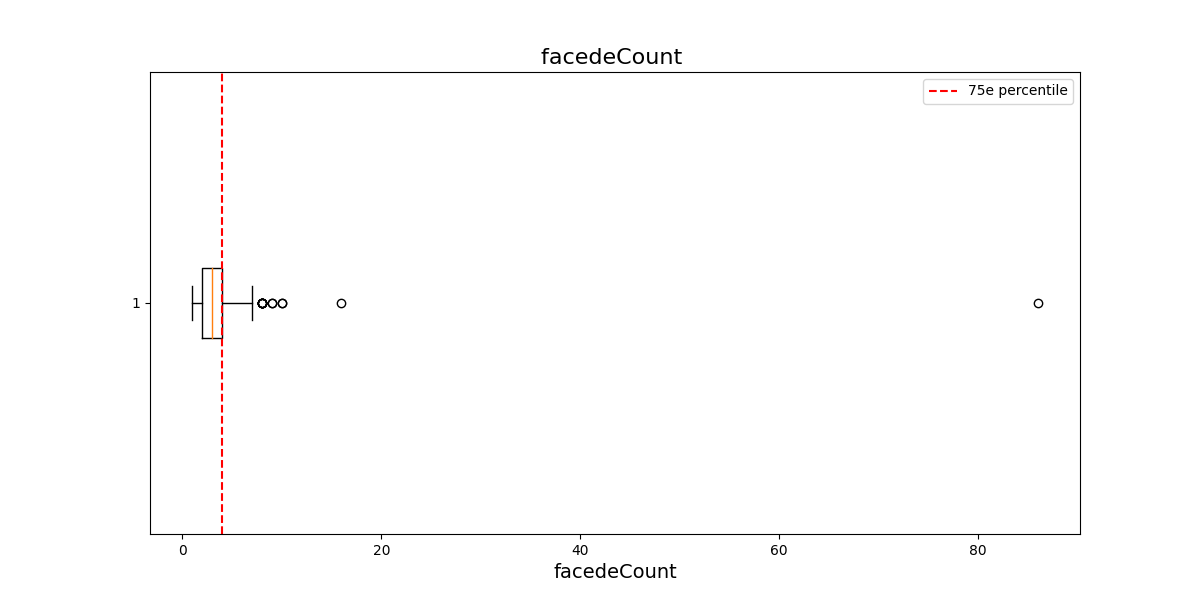

90ᵉ percentile : 4 
95ᵉ percentile : 4 
10ᵉ percentile : 2 
Biens > p90 : 54 soit 0.07%
Biens > p95 : 54 soit 0.07%
Biens < p10 : 403 soit 0.50%


In [ ]:
#Datavisualization for outliers
# plt.figure(figsize=(12,6))
# sns.boxplot(x=df['facedeCount'], color='skyblue')
# plt.title('facedeCount ', fontsize=16)
# plt.xlabel('facedeCount', fontsize=14)
# plt.show()

data = df["facedeCount"].dropna()
p95 = np.percentile(data, 95)

plt.figure(figsize=(12,6))
plt.boxplot(data,  vert=False, showfliers=True)
plt.axvline(p95, color="red", linestyle="--", label="75e percentile")
plt.title('facedeCount ', fontsize=16)
plt.xlabel('facedeCount', fontsize=14)
plt.legend()
plt.show()

# p90 and p95
percentiles = df['facedeCount'].quantile([0.10, 0.90, 0.95])
p90 = percentiles.loc[0.90]
p95 = percentiles.loc[0.95]
p10 = percentiles.loc[0.10]


print(f"90ᵉ percentile : {p90:.0f} ")
print(f"95ᵉ percentile : {p95:.0f} ")
print(f"10ᵉ percentile : {p10:.0f} ")

n_above_p90 = (df['facedeCount'] > p90).sum()
n_above_p95 = (df['facedeCount'] > p95).sum()
n_below_p10 = (df['facedeCount'] < p10).sum()
total = len(df)

print(f"Biens > p90 : {n_above_p90} soit {n_above_p90/total:.2%}")
print(f"Biens > p95 : {n_above_p95} soit {n_above_p95/total:.2%}")
print(f"Biens < p10 : {n_below_p10} soit {n_below_p10/total:.2%}")
print(df['facedeCount'].mode)

Keep bedrooms <= 7

In [ ]:
df = df[
    (df["bedroomCount"] <= 7) | df["bedroomCount"].isna()
]


Keep houses contructed between 1850 and 2025

In [ ]:
df = df[
    (df["buildingConstructionYear"].between(1850, 2025)) | df["buildingConstructionYear"].isna()
]

Bathrooms count <= 3

In [ ]:
df = df[
    (df["bathroomCount"] <= 3) | df["bathroomCount"].isna()
]

Habitable surface

In [ ]:
# Fourchettte entre 5 et 500 m² pour rester dans un marché immo le plus représentatif
df_domain = df[(df["habitableSurface"] >= 5) & (df["habitableSurface"] <= 500)]

Facede count
Max. 4

In [ ]:
df = df[
    (df["facedeCount"] <= 4) | df["facedeCount"].isna()
]